In [12]:
import os
import pandas as pd
from utils.evaluation_utils import get_temporal_analysis_results, calculate_percentage_improvement
import matplotlib.pyplot as plt

if "notebooks" in os.getcwd():
    os.chdir("..")
import matplotlib as mpl
import numpy as np
from pathlib import Path

In [13]:
# Remove comment out for latex style font rendering (you need it installed on your system)
mpl.rcParams.update(
    {
        "text.usetex": True,
        "font.family": "serif",
        "font.serif": ["Latin Modern Roman"],
        "axes.labelsize": 16,  ##25 for multiplot, 16 otherwise
        "font.size": 16,  ##25 for multiplot, 16 otherwise
        "legend.fontsize": 16,
        "xtick.labelsize": 16,
        "ytick.labelsize": 16,
        "text.latex.preamble": r"\usepackage{amsmath}",
        "legend.title_fontsize": 16,
    }
)

In [14]:
temporal_results_path = Path("data/results/temporal_analysis.csv")
if not temporal_results_path.exists():
    temporal_results = get_temporal_analysis_results(
        {
            1: [i for i in range(320, 375)] + [i for i in range(268, 316)],
            4: [i for i in range(201, 298)],
            8: [i for i in range(152, 249)] + [249, 250, 251],
        }
    )
    temporal_results.dropna(inplace=True)
    temporal_results.to_csv(temporal_results_path, index=False)

In [15]:
def plot_temporal_results(
    results_df,
    architectures,
    resolutions,
    look_back_hours,
    horizons,
    legend_loc="lower right",
    is_detailed=False,
):
    plot_legend = True

    for horizon in horizons:
        horizon_subset = results_df[results_df["forecasting_hours"] == horizon]
        rmse_vals = horizon_subset[horizon_subset["model_architecture"].isin(architectures)]["RMSE"]
        persistence_vals = results_df[
            (results_df["model_architecture"] == "Persistence")
            & (results_df["forecasting_hours"] == horizon)
        ]["RMSE"]

        global_min = rmse_vals.min()
        global_max = rmse_vals.max()

        margin = 0.05 * (global_max - global_min)
        y_min, y_max = global_min - margin, global_max + margin

        persistence_rmse = persistence_vals.values[0] if len(persistence_vals) > 0 else None

        for arch in architectures:
            subset = horizon_subset[horizon_subset["model_architecture"] == arch]

            plt.figure(figsize=(8, 6))
            for res in resolutions:
                sub_res = subset[
                    (subset["resolution"] == res)
                    & (subset["look_back_hours"].isin(look_back_hours))
                ]
                sub_res = sub_res.sort_values("look_back_hours")

                plt.plot(
                    sub_res["look_back_hours"],
                    sub_res["RMSE"],
                    marker="o",
                    label=str(res),
                )

            plt.xlabel("$L$ [h]")
            plt.ylabel(
                r"$\text{RMSE}^{\mathcal{D}_{\text{eval}}}_\text{"
                + arch
                + r"} \; \left[ \frac{m}{s} \right]$"
            )
            plt.title(f"{arch} with " + rf"$H = {horizon}$ h")
            plt.ylim(y_min, y_max)

            if plot_legend:
                plt.legend(title="Legend", loc=legend_loc)
                plot_legend = False

            plt.grid(True)
            plt.tight_layout()
            plt.savefig(
                f"notebooks/plots/temporal_analysis/{horizon}_hour_forecasting_{arch}_abs{"_detailed" if is_detailed else ""}",
                dpi=300,
            )
            plt.show()
            plt.close()

            if persistence_rmse is not None and persistence_rmse != 0:
                plt.figure(figsize=(8, 6))
                for res in resolutions:
                    sub_res = subset[
                        (subset["resolution"] == res)
                        & (subset["look_back_hours"].isin(look_back_hours))
                    ]
                    sub_res = sub_res.sort_values("look_back_hours")

                    improvement_percent = calculate_percentage_improvement(
                        persistence_rmse, sub_res["RMSE"]
                    )

                    plt.plot(
                        sub_res["look_back_hours"],
                        improvement_percent,
                        marker="o",
                        label=str(res),
                    )

                plt.xlabel("$L$ [h]")
                plt.ylabel(
                    r"$\text{rRMSE}_{\text{"
                    + arch
                    + r"},\text{Persistence}}^{\mathcal{D}_\text{eval}}$ [\%]"
                )
                plt.title(f"{arch} with " + rf"$H = {horizon}$ h")
                plt.ylim(
                    calculate_percentage_improvement(persistence_rmse, y_max),
                    calculate_percentage_improvement(persistence_rmse, y_min),
                )
                plt.grid(True)
                plt.tight_layout()
                plt.savefig(
                    f"notebooks/plots/temporal_analysis/{horizon}_hour_forecasting_{arch}_rel{"_detailed" if is_detailed else ""}",
                    dpi=300,
                )
                plt.show()
                plt.close()

### 1-Hour-Forecasting


In [ ]:
results_df = pd.read_csv(temporal_results_path)
architectures = ["MLP", "LSTM", "GCN", "GCN-LSTM"]
resolutions = ["10min", "20min", "30min", "60min"]
look_back_hours = [1, 4, 8, 12]
horizons = [1]
results_df["forecasting_hours"] = results_df["forecasting_hours"].astype(int)
arch_to_label = {
    "mlp": "MLP",
    "lstm": "LSTM",
    "gcn": "GCN",
    "gcn_lstm": "GCN-LSTM",
    "persistence": "Persistence",
}
results_df["model_architecture"] = results_df["model_architecture"].map(arch_to_label)

plot_temporal_results(results_df, architectures, resolutions, look_back_hours, horizons)

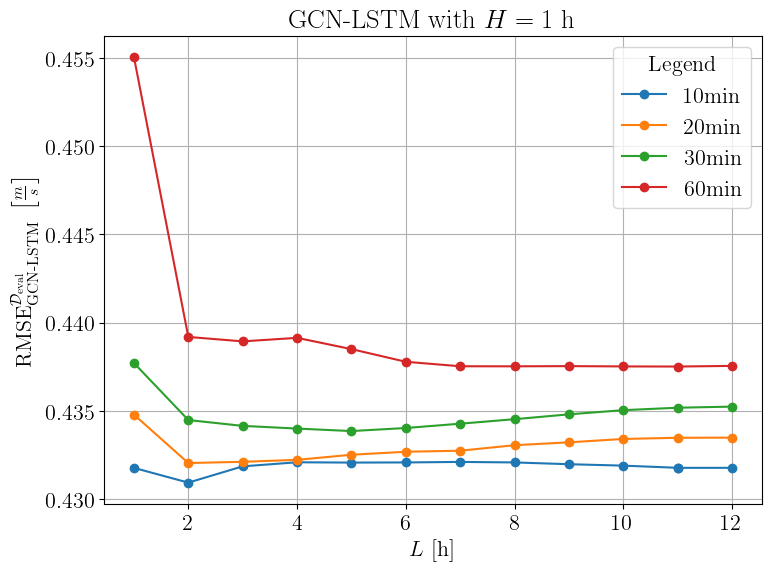

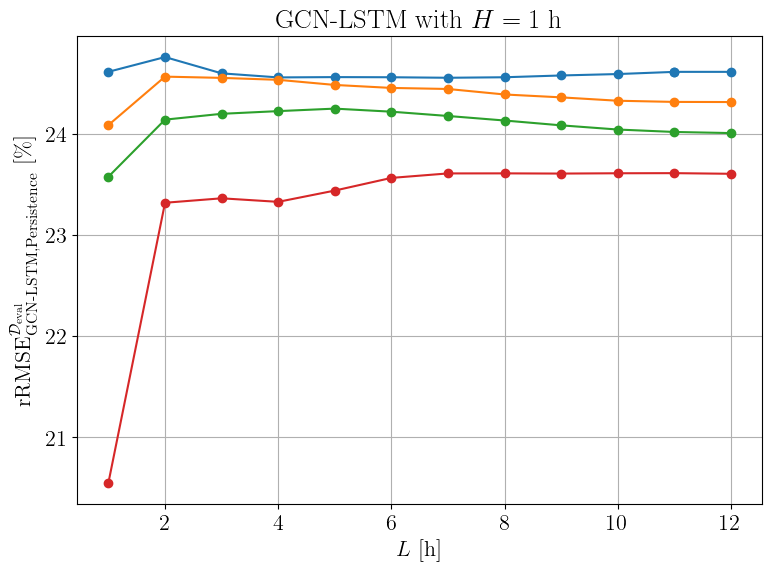

In [ ]:
architectures = ["GCN-LSTM"]
horizons = [1]
look_back_hours = [i for i in range(1, 13)]

plot_temporal_results(
    results_df,
    architectures,
    resolutions,
    look_back_hours,
    horizons,
    legend_loc="upper right",
    is_detailed=True,
)

#### Closer look at model architectures


In [ ]:
def print_improvement_over_persistence(forecasting_hours):
    worst_dl_rmse = results_df.loc[
        results_df[
            (results_df["model_architecture"] != "Persistence")
            & (results_df["forecasting_hours"] == forecasting_hours)
        ]["RMSE"].idxmax()
    ]
    persistence_rmse = results_df[
        (results_df["model_architecture"] == "Persistence")
        & (results_df["forecasting_hours"] == forecasting_hours)
    ]["RMSE"]

    rrmse_worst = calculate_percentage_improvement(persistence_rmse, worst_dl_rmse["RMSE"])
    print(
        f"The relative improvement of worst RMSE over persistence: {rrmse_worst} ({worst_dl_rmse[["model_architecture", "look_back_hours", "resolution"]]})"
    )

    best_dl_rmse = results_df.loc[
        results_df[
            (results_df["model_architecture"] != "Persistence")
            & (results_df["forecasting_hours"] == forecasting_hours)
        ]["RMSE"].idxmin()
    ]
    rrmse_best = calculate_percentage_improvement(persistence_rmse, best_dl_rmse["RMSE"])
    print(
        f"The relative improvement of best RMSE over persistence: {rrmse_best} ({best_dl_rmse[["model_architecture", "look_back_hours", "resolution"]]})"
    )


print_improvement_over_persistence(1)

The relative improvement of worst RMSE over persistence: 75    16.669588
Name: RMSE, dtype: float64 (model_architecture      MLP
look_back_hours          12
resolution            10min
Name: 2, dtype: object)
The relative improvement of best RMSE over persistence: 75    24.757139
Name: RMSE, dtype: float64 (model_architecture    GCN-LSTM
look_back_hours              2
resolution               10min
Name: 48, dtype: object)


In [ ]:
def print_performance_spread_per_model(forecasting_hours):
    cfg_spread_per_model = (
        results_df.groupby(["forecasting_hours", "model_architecture"])["RMSE"]
        .agg(min_rmse="min", max_rmse="max")
        .reset_index()
    )

    cfg_spread_per_model["rmse_diff"] = (
        cfg_spread_per_model["max_rmse"] - cfg_spread_per_model["min_rmse"]
    )
    cfg_spread_per_model["rrmse"] = calculate_percentage_improvement(
        cfg_spread_per_model["max_rmse"], cfg_spread_per_model["min_rmse"]
    )

    display(cfg_spread_per_model[cfg_spread_per_model["forecasting_hours"] == forecasting_hours])


print_performance_spread_per_model(1)

,forecasting_hours,model_architecture,min_rmse,max_rmse,rmse_diff,rrmse
0,1,GCN,0.433998,0.458020,0.024022,5.244802
1,1,GCN-LSTM,0.430938,0.455051,0.024112,5.298854
2,1,LSTM,0.441223,0.450135,0.008911,1.979680
3,1,MLP,0.439182,0.477258,0.038076,7.978041
4,1,Persistence,0.572730,0.572730,0.000000,0.000000


In [ ]:
initial_results = results_df[
    results_df["look_back_hours"].isin([1, 4, 8, 12])
    | (results_df["model_architecture"] == "Persistence")
]
best_cfg_per_model_df = initial_results.loc[
    initial_results.groupby(["forecasting_hours", "model_architecture"])["RMSE"].idxmin()
].reset_index(drop=True)

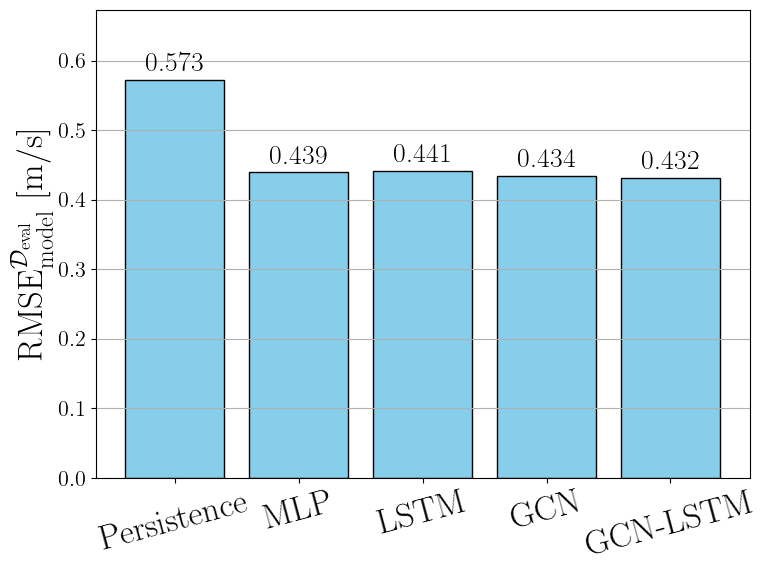

In [ ]:
def plot_best_config_per_model(forecasting_hours):
    best_cfg_per_model_filtered_horizon = best_cfg_per_model_df[
        (best_cfg_per_model_df["forecasting_hours"] == forecasting_hours)
    ]
    plt.figure(figsize=(8, 6))

    order = ["Persistence", "MLP", "LSTM", "GCN", "GCN-LSTM"]
    df_sorted = (
        best_cfg_per_model_filtered_horizon.set_index("model_architecture").loc[order].reset_index()
    )

    bars = plt.bar(
        df_sorted["model_architecture"], df_sorted["RMSE"], color="skyblue", edgecolor="black"
    )

    plt.ylabel(r"RMSE$^{\mathcal{D}_{\text{eval}}}_\text{model}$ [m/s]", fontdict={"fontsize": 25})
    plt.ylim(top=max(df_sorted["RMSE"]) + 0.1)

    plt.xticks(rotation=15, fontsize=25)

    for bar in bars:
        height = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width() / 2,
            height + 0.005,
            f"{height:.3f}",
            ha="center",
            va="bottom",
            fontsize=20,
        )

    plt.grid(axis="y")
    plt.tight_layout()
    plt.savefig(
        f"notebooks/plots/temporal_analysis/{forecasting_hours}_hour_forecasting_model_comp.png",
        dpi=300,
        transparent=False,
    )
    plt.show()


plot_best_config_per_model(1)

In [ ]:
def print_rrmse_best_model_best_cfg_vs_worst_model_best_cfg(forecasting_hours):
    best_cfg_per_model_df_filtered = best_cfg_per_model_df[
        (best_cfg_per_model_df["model_architecture"] != "Persistence")
        & (best_cfg_per_model_df["forecasting_hours"] == forecasting_hours)
    ]
    best_rmse = best_cfg_per_model_df_filtered["RMSE"].min()
    worst_rmse = best_cfg_per_model_df_filtered["RMSE"].max()

    print(
        f"The percentage improvement of the best model over the worst model, both trained with their optimal temporal configuration, is: {calculate_percentage_improvement(worst_rmse, best_rmse)} %"
    )


print_rrmse_best_model_best_cfg_vs_worst_model_best_cfg(1)

The percentage improvement of the best model over the worst model, both trained with their optimal temporal configuration, is: 2.14183090531177 %


In [ ]:
def print_best_cfg_per_model(forecasting_hours):
    print(
        best_cfg_per_model_df[
            (best_cfg_per_model_df["forecasting_hours"] == forecasting_hours)
            & (best_cfg_per_model_df["model_architecture"] != "Persistence")
        ].loc[:, ["model_architecture", "resolution", "look_back_hours"]]
    )


print_best_cfg_per_model(1)

  model_architecture resolution  look_back_hours
0                GCN      10min                1
1           GCN-LSTM      10min                1
2               LSTM      20min               12
3                MLP      10min                1


In [ ]:
def print_optimal_lb_window_per_resolution(forecasting_hours, model):
    print(
        results_df.loc[
            results_df[
                (results_df["forecasting_hours"] == forecasting_hours)
                & (results_df["model_architecture"] == model)
            ]
            .groupby(["resolution"])["RMSE"]
            .idxmin(),
            ["resolution", "look_back_hours"],
        ]
    )


print_optimal_lb_window_per_resolution(1, "GCN-LSTM")

   resolution  look_back_hours
48      10min                2
55      20min                2
62      30min                5
74      60min               11


In [ ]:
def print_final_best_model(forecasting_hours):
    best_model = results_df.loc[
        results_df[results_df["forecasting_hours"] == forecasting_hours]["RMSE"].idxmin()
    ]
    persistence_rmse = results_df[
        (results_df["model_architecture"] == "Persistence")
        & (results_df["forecasting_hours"] == forecasting_hours)
    ]["RMSE"]
    print(f"Best model: {best_model}")
    print(
        f"Persistence improvement: {calculate_percentage_improvement(persistence_rmse, best_model["RMSE"])}"
    )


print_final_best_model(1)

Best model: forecasting_hours            1
run_id                     320
resolution               10min
look_back_hours              2
model_architecture    GCN-LSTM
RMSE                  0.430938
Name: 48, dtype: object
Persistence improvement: 75    24.757139
Name: RMSE, dtype: float64


### 4-Hour-Forecasting


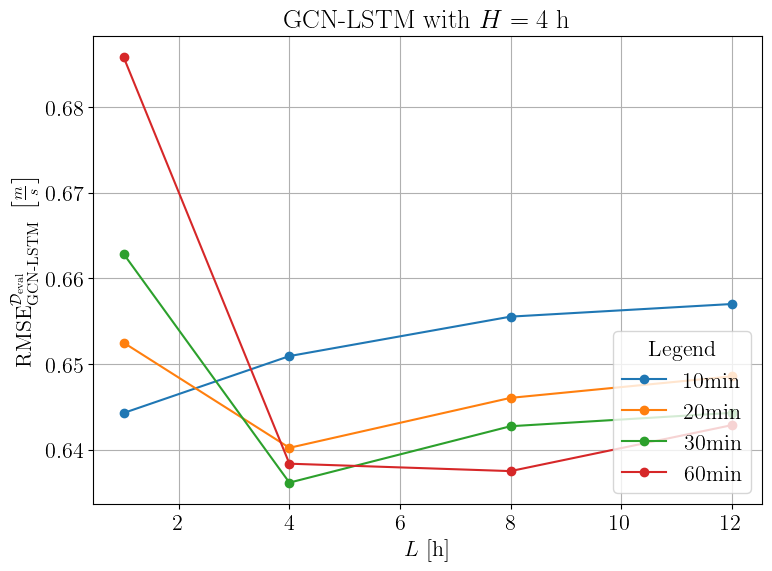

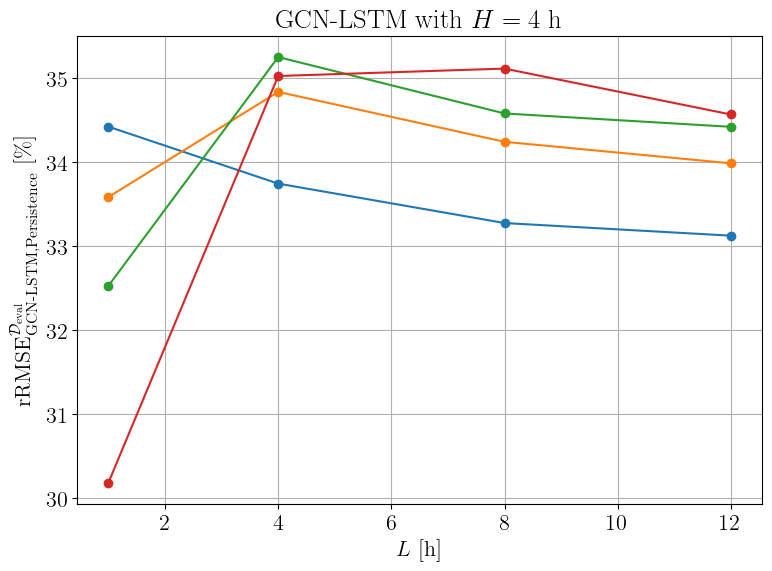

In [ ]:
look_back_hours = [1, 4, 8, 12]
horizons = [4]
plot_temporal_results(results_df, architectures, resolutions, look_back_hours, horizons)

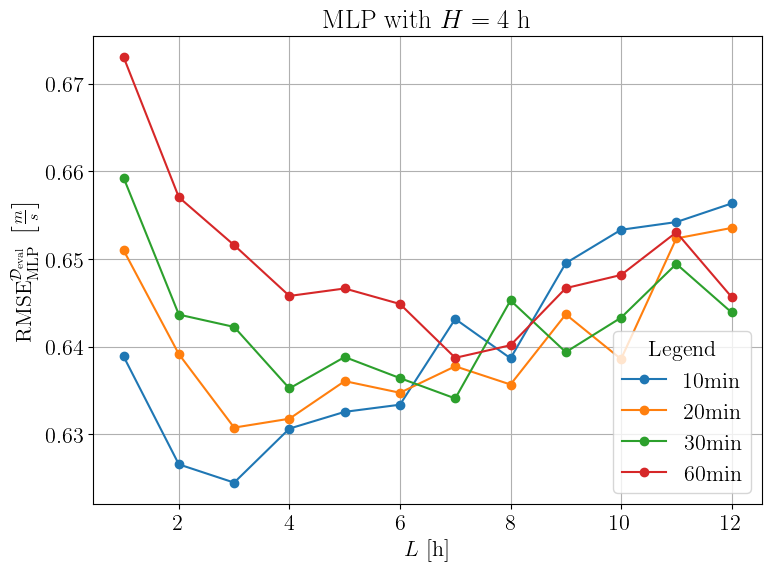

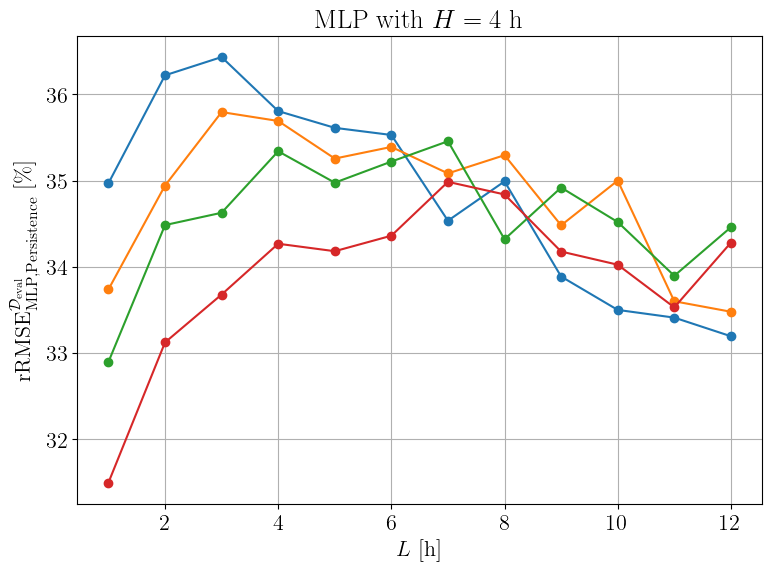

In [ ]:
look_back_hours = [i for i in range(1, 13)]
architectures = ["MLP"]
plot_temporal_results(results_df, architectures, resolutions, look_back_hours, horizons)

In [ ]:
print_improvement_over_persistence(4)

The relative improvement of worst RMSE over persistence: 194    27.316764
Name: RMSE, dtype: float64 (model_architecture      GCN
look_back_hours           1
resolution            60min
Name: 142, dtype: object)
The relative improvement of best RMSE over persistence: 194    36.433872
Name: RMSE, dtype: float64 (model_architecture      MLP
look_back_hours           3
resolution            10min
Name: 163, dtype: object)


In [ ]:
print_performance_spread_per_model(4)

,forecasting_hours,model_architecture,min_rmse,max_rmse,rmse_diff,rrmse
5,4,GCN,0.637829,0.714051,0.076222,10.674578
6,4,GCN-LSTM,0.636146,0.685841,0.049694,7.245752
7,4,LSTM,0.640824,0.659963,0.019138,2.899931
8,4,MLP,0.624483,0.673033,0.048550,7.213577
9,4,Persistence,0.982415,0.982415,0.000000,0.000000


In [ ]:
print_best_cfg_per_model(4)

  model_architecture resolution  look_back_hours
5                GCN      10min                4
6           GCN-LSTM      30min                4
7               LSTM      20min                1
8                MLP      10min                4


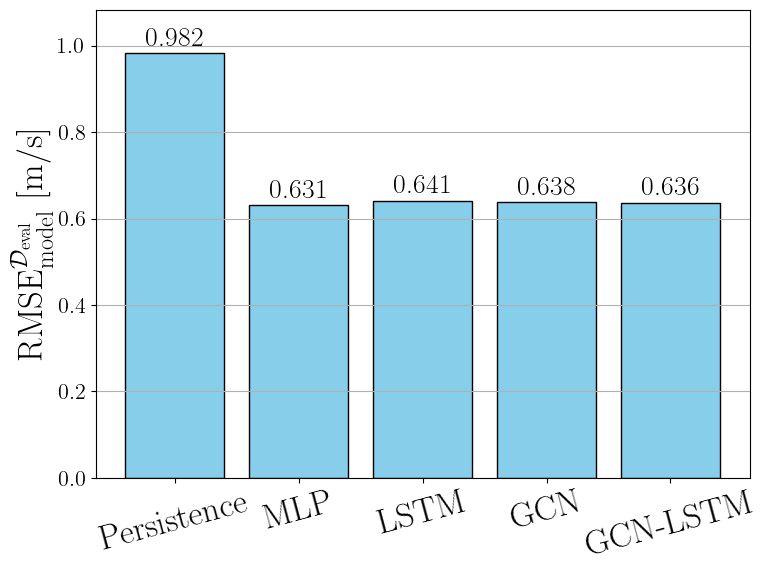

In [ ]:
plot_best_config_per_model(4)

In [ ]:
print_rrmse_best_model_best_cfg_vs_worst_model_best_cfg(4)

The percentage improvement of the best model over the worst model, both trained with their optimal temporal configuration, is: 1.5882040927368113 %


In [ ]:
print_optimal_lb_window_per_resolution(4, "MLP")

    resolution  look_back_hours
163      10min                3
171      20min                3
182      30min                7
190      60min                7


In [ ]:
print_final_best_model(4)

Best model: forecasting_hours            4
run_id                     266
resolution               10min
look_back_hours              3
model_architecture         MLP
RMSE                  0.624483
Name: 163, dtype: object
Persistence improvement: 194    36.433872
Name: RMSE, dtype: float64


#### 8-Hour-Forecasting


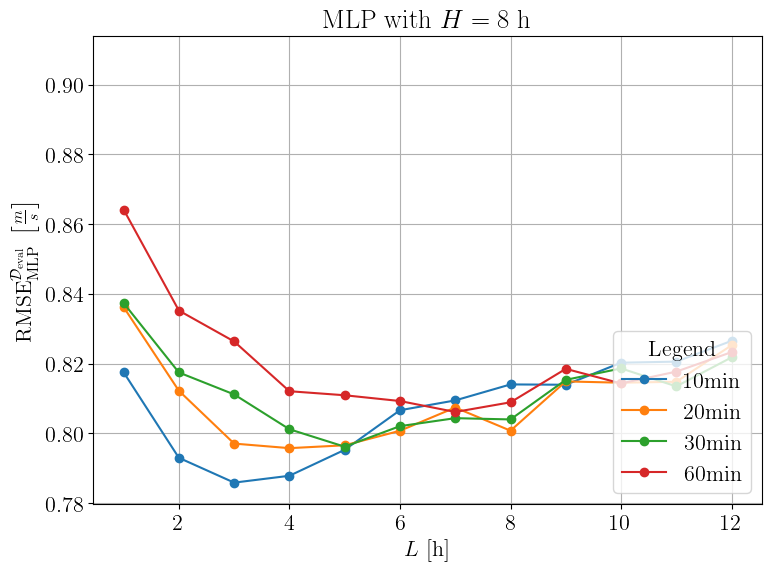

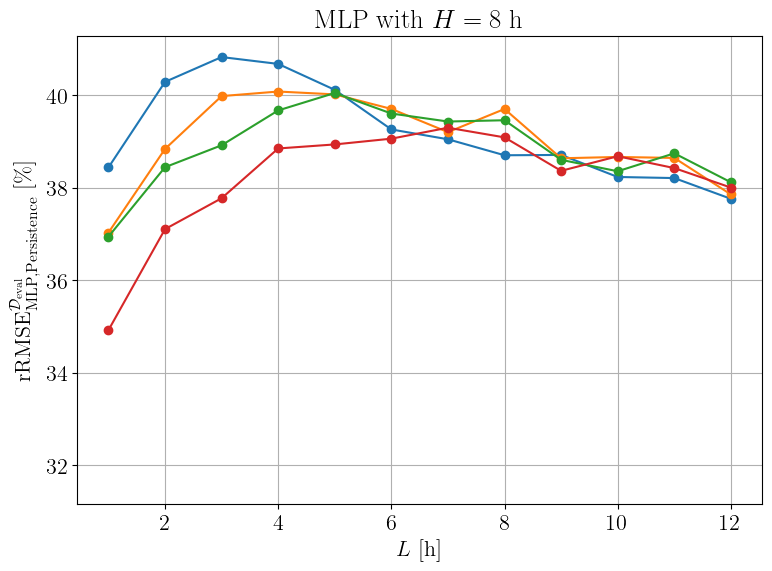

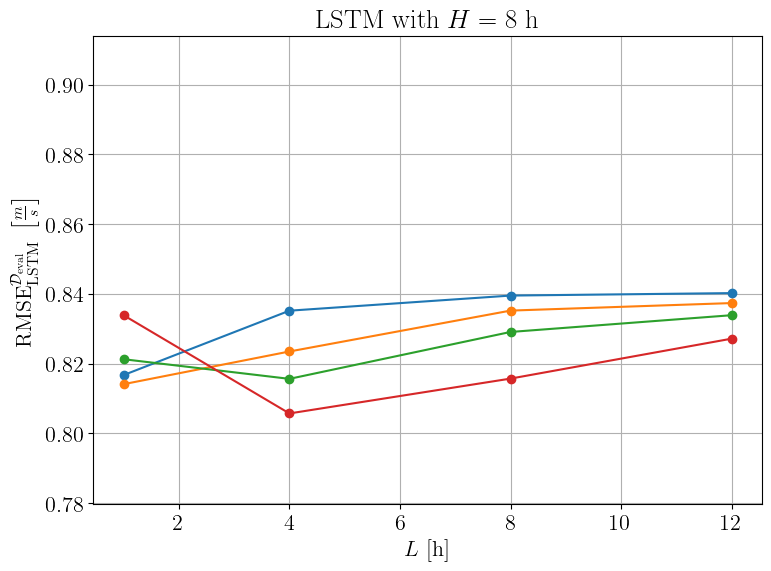

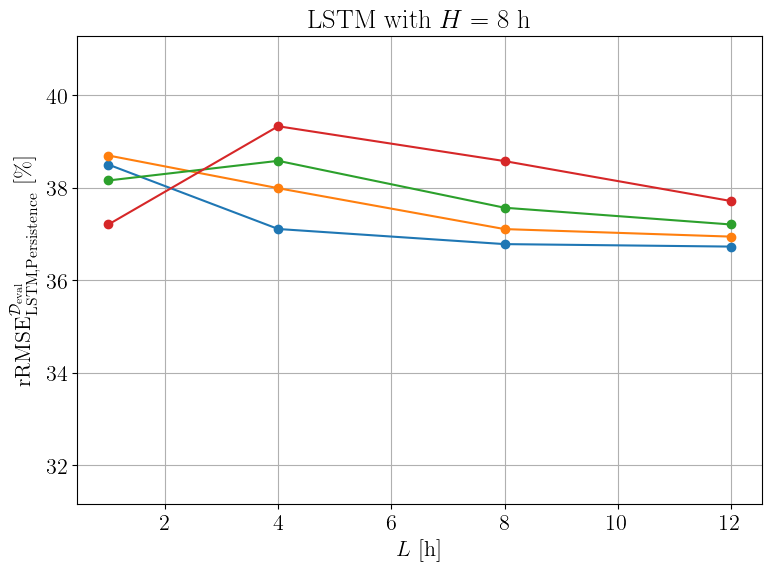

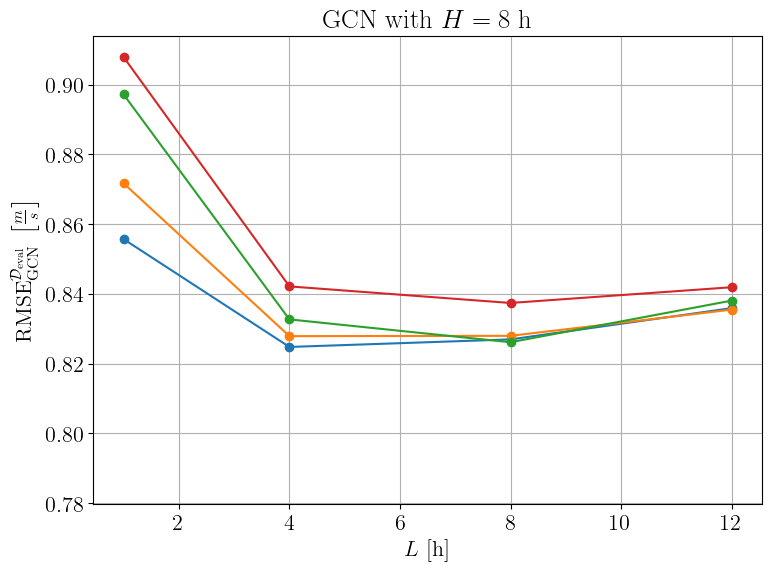

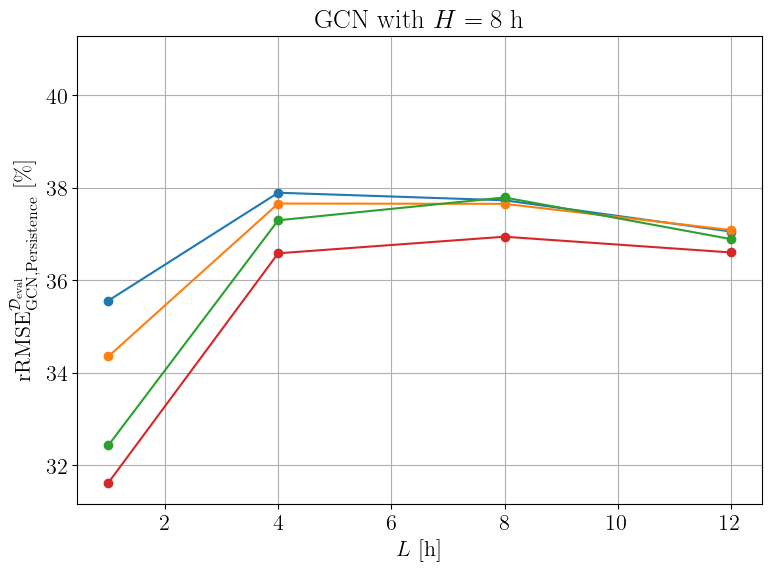

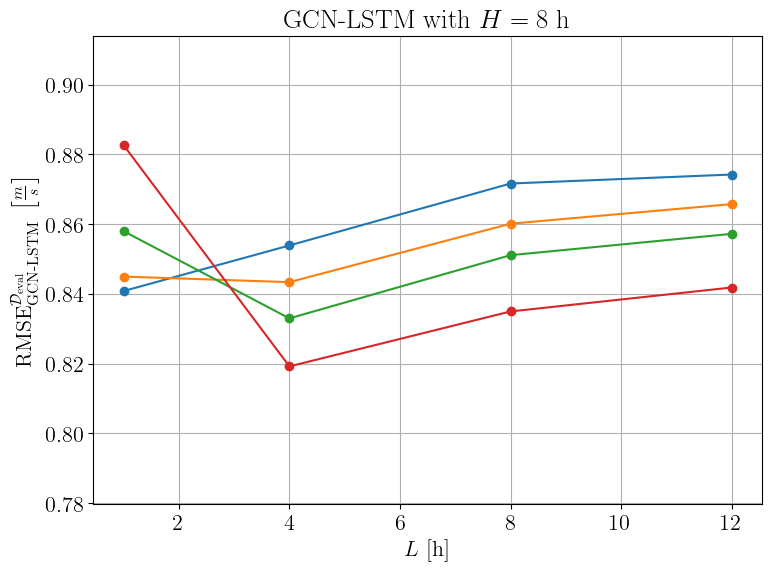

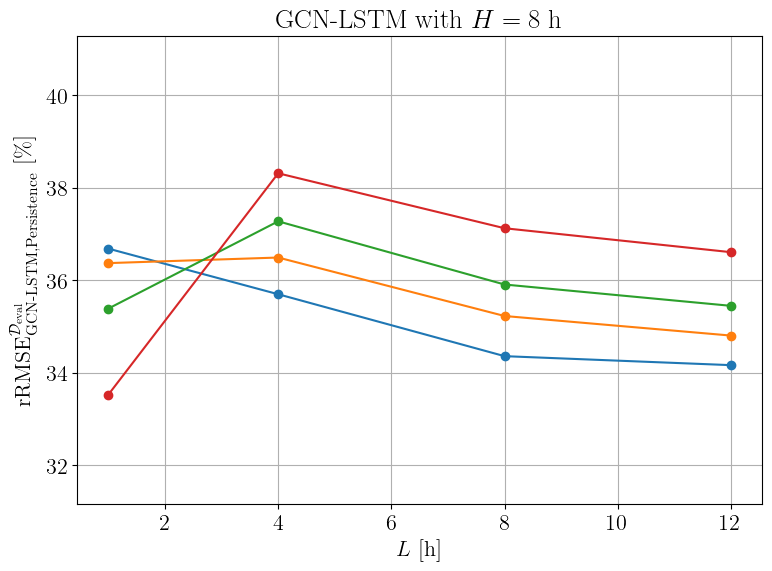

In [ ]:
look_back_hours = [i for i in range(1, 13)]
horizons = [8]
architectures = ["MLP", "LSTM", "GCN", "GCN-LSTM"]
plot_temporal_results(results_df, architectures, resolutions, look_back_hours, horizons)

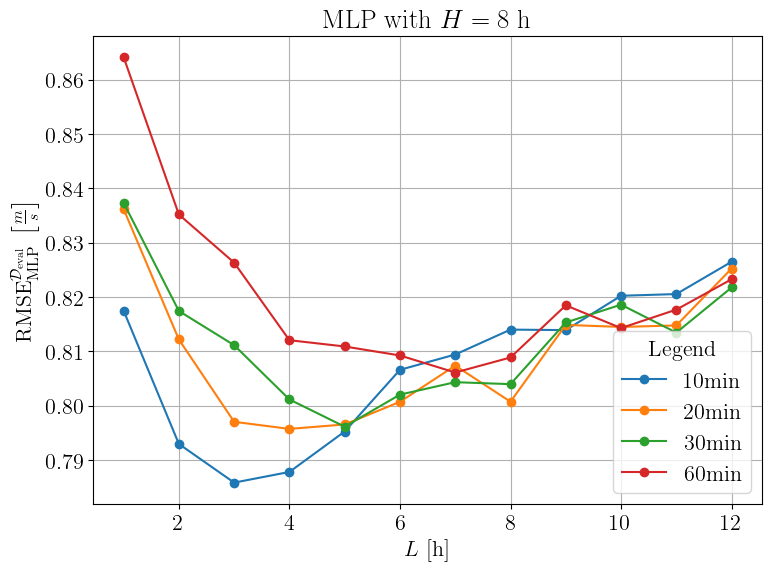

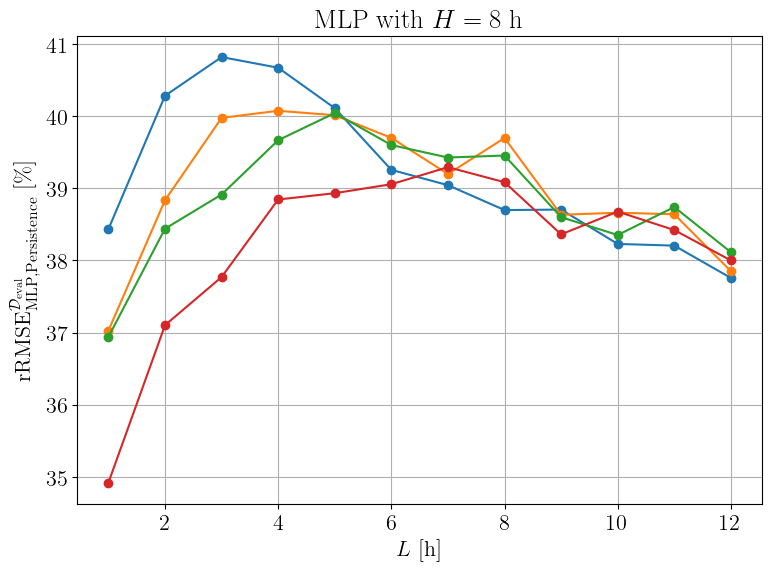

In [ ]:
look_back_hours = [i for i in range(13)]
architectures = ["MLP"]
plot_temporal_results(results_df, architectures, resolutions, look_back_hours, horizons, is_detailed=True)

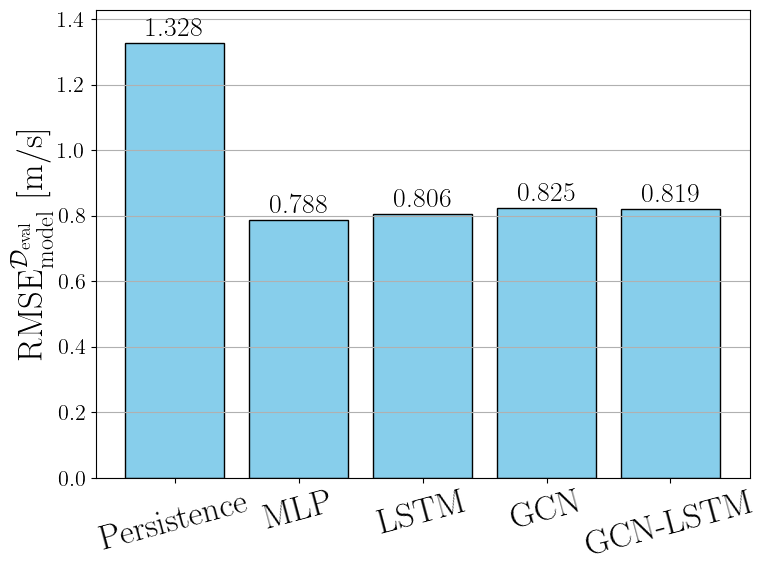

In [ ]:
plot_best_config_per_model(8)

In [ ]:
print_best_cfg_per_model(8)

   model_architecture resolution  look_back_hours
10                GCN      10min                4
11           GCN-LSTM      60min                4
12               LSTM      60min                4
13                MLP      10min                4


In [ ]:
print_rrmse_best_model_best_cfg_vs_worst_model_best_cfg(8)

The percentage improvement of the best model over the worst model, both trained with their optimal temporal configuration, is: 4.479854391823368 %


In [ ]:
print_improvement_over_persistence(8)

The relative improvement of worst RMSE over persistence: 288    31.626571
Name: RMSE, dtype: float64 (model_architecture      GCN
look_back_hours           1
resolution            60min
Name: 236, dtype: object)
The relative improvement of best RMSE over persistence: 288    40.818951
Name: RMSE, dtype: float64 (model_architecture      MLP
look_back_hours           3
resolution            10min
Name: 257, dtype: object)


In [ ]:
print_optimal_lb_window_per_resolution(8, "MLP")

    resolution  look_back_hours
257      10min                3
200      20min                4
274      30min                5
284      60min                7


In [ ]:
print_final_best_model(8)

NameError: name 'print_final_best_model' is not defined

In [ ]:
print_performance_spread_per_model(8)

,forecasting_hours,model_architecture,min_rmse,max_rmse,rmse_diff,rrmse
10,8,GCN,0.824748,0.907896,0.083148,9.158290
11,8,GCN-LSTM,0.819169,0.882626,0.063457,7.189529
12,8,LSTM,0.805680,0.840195,0.034516,4.108062
13,8,MLP,0.785835,0.864168,0.078333,9.064518
14,8,Persistence,1.327849,1.327849,0.000000,0.000000
